## Import modules/scripts and optimize portfolio weights:

In [22]:
from datetime import date, timedelta
from cov_matrix import MPTCovMat
from optimizer import WeightOptimizer
from JSONReader import read_json
import pandas as pd
import yfinance as yf
import torch

ticker_list = read_json('omxs30.json')
tickers = yf.Tickers(ticker_list)
start = date(2021,1,1)
end = date(2023,12,31)
rr = 0.027
rr_period = timedelta(120)

#get data
data = MPTCovMat(tickers=tickers,start=start,end=end)
returns = data.log_return_df
col_indices = data.col_indices
asset_names = [col_indices[i] for i in sorted(col_indices.keys())]
num_iter = 10000
allocator = WeightOptimizer(lr=1e-3,returns=torch.tensor(returns.values),risk_free=rr,risk_free_period=rr_period,num_iter=num_iter)
cos_losses, pf_returns = allocator.optimize_weights(0.2,0.3,0.5)
weights = pd.DataFrame(allocator.alloc_weights.numpy(force=True), index=asset_names, columns=['Weights'])
weights.index.name = 'Ticker'
weights['Weights %'] = weights['Weights']*100
weights['Weights %'].to_csv('weights.csv')
print(weights['Weights %'])

[*********************100%***********************]  30 of 30 completed


Ticker
ABB.ST          9.504359
ALFA.ST         2.708920
ASSA-B.ST       1.468645
ATCO-A.ST       4.247388
ATCO-B.ST       0.395014
AZN.ST          2.654258
BOL.ST          0.740785
ELUX-B.ST       0.387334
ERIC-B.ST       0.413992
ESSITY-B.ST     0.523507
EVO.ST          1.179746
GETI-B.ST       1.142616
HEXA-B.ST       0.346275
HM-B.ST         1.197533
INVE-B.ST      52.467148
KINV-B.ST       0.052362
NDA-SE.ST       1.850516
NIBE-B.ST       0.689064
SAAB-B.ST       3.830173
SAND.ST         0.137598
SBB-B.ST        0.646857
SCA-B.ST        0.681576
SEB-A.ST        5.334044
SHB-A.ST        0.499663
SINCH.ST        0.658969
SKF-B.ST        0.377347
SWED-A.ST       1.080813
TEL2-B.ST       2.264169
TELIA.ST        0.231720
VOLV-B.ST       2.287617
Name: Weights %, dtype: float32


### Plot sharpe ratios to number of iterations

Text(0, 0.5, 'COS Loss')

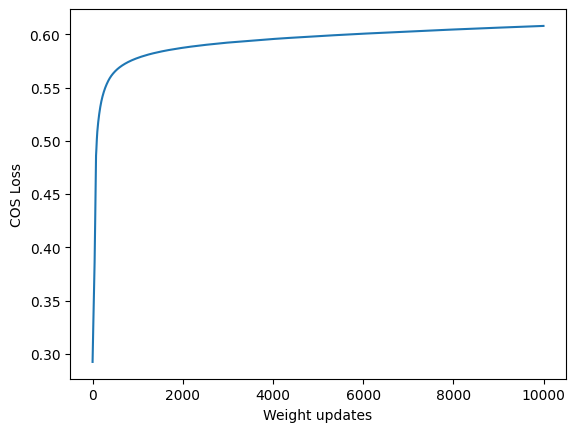

In [21]:
import matplotlib.pyplot as plt
x_df = pd.DataFrame(range(0,num_iter))
plt.plot(x_df,cos_losses.numpy(force=True),)
plt.xlabel('Weight updates')
plt.ylabel('COS Loss')

## Backtesting

### Get comparison data

In [23]:
from backtesting import BackTester
import numpy as np
test_start=date(2024,1,1)
test_end=date(2024,10,16 )
tester = BackTester(test_weights=pd.DataFrame(weights['Weights']),start=test_start,end=test_end,tickers=tickers)
omxs30 = yf.Ticker('^OMX').history(start=test_start,end=test_end,auto_adjust=True)
omxs30_returns:pd.DataFrame = np.log(omxs30['Close']/omxs30['Close'].shift(1))
omxs30_returns.dropna(inplace=True)
omxs30_cumulative = (omxs30_returns+1).cumprod(0)-1

[*********************100%***********************]  30 of 30 completed


TESTER


### Plot  results

Comparison portfolio return: 6.94 %
Optimized portfolio return: 26.55 %
Percentage point difference: 19.61 pp
Percentage difference: 282.56 %


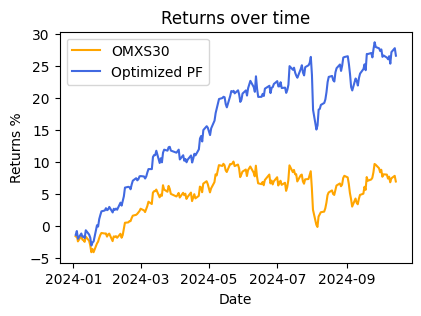

In [24]:
import matplotlib.dates as mdates
comp_returns = pd.DataFrame(omxs30_cumulative)
test_returns = tester.cumulative_returns(tester.test_portfolio_returns)
ax1=plt.subplot(1,2,1)
ax1.set_title('Returns over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns %')
ax1.figure.set_size_inches(10,3)
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2,maxticks=8))
ax1.plot(comp_returns.mul(100),color='orange')
ax1.plot(test_returns.mul(100),color='royalblue')
ax1.legend(['OMXS30','Optimized PF'])
comp_final_return = round((comp_returns.iloc[-1].values*100).item(),2)
optimized_final_return = round((test_returns.iloc[-1,:].values*100).item(),2)
comp_optim_diff = optimized_final_return-comp_final_return

print(f'Comparison portfolio return: {str(comp_final_return)+' %'}')
print(f'Optimized portfolio return: {str(optimized_final_return)+' %'}')
print(f'Percentage point difference: {round(comp_optim_diff,2)} pp')
perc_diff = round(((optimized_final_return/comp_final_return)-1)*100,2)
print(f'Percentage difference: {round(((optimized_final_return/comp_final_return)-1)*100,2)} %')